In [3]:
import numpy as np
import pandas as pd
import glob
import locale
import os.path
import requests
import sys
import codecs
import re
import spacy
import string
import pickle as pkl
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import Dataset
import random
import csv
import io
from collections import Counter
import matplotlib.pyplot as plt

### Read and tokenize data

In [4]:
label_convert = {'entailment': int(0), 'neutral': int(1), 'contradiction': int(2)}
def normalize_text(text):
    text[0] = re.sub(r"([\.\",\(\)!\?;:-])", "", text[0])
    text[0] = str(text[0]).lower().replace(' .', '').split()
    text[1] = re.sub(r"([\.\",\(\)!\?;:-])", "", text[1])
    text[1]= str(text[1]).lower().replace(' .', '').split()
    text[2]= label_convert[str(text[2])]
    return text

def tokenize(filepath):
    '''returns cleaned dataset [[[sentence1],[sentence2],label],...]'''
    dataset = []
    with open(filepath) as tsvfile:
        reader = csv.reader(tsvfile, delimiter='\t')
        next(reader)
        for row in reader:
            dataset.append(normalize_text(row))
    return dataset

In [5]:
train_set = tokenize('/scratch/hb1500/NLP/HW2/hw2_data/snli_train.tsv')
val_set = tokenize('/scratch/hb1500/NLP/HW2/hw2_data/snli_val.tsv')

In [6]:
train_set[0]

[['a',
  'young',
  'girl',
  'in',
  'a',
  'pink',
  'shirt',
  'sitting',
  'on',
  'a',
  'dock',
  'viewing',
  'a',
  'body',
  'of',
  'water'],
 ['a', 'young', 'girl', 'watching', 'the', 'sunset', 'over', 'the', 'water'],
 1]

### Collect all tokens in the training set

In [7]:
def all_tokens_list(train_data):
    """returns all tokens of instruction (all steps) for creating vocabulary"""
    all_tokens = []
    for sample in train_data:
        all_tokens += sample[0][:]
        all_tokens += sample[1][:]
    return all_tokens

In [8]:
all_train_tokens = all_tokens_list(train_set)

In [9]:
print('Totoal number of unique words is', len(Counter(all_train_tokens).keys()))

Totoal number of unique words is 20729


### Create the vocabulary of most common 20,000 tokens in the training set.

In [10]:
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1
MAX_VOCAB_SIZE = 20000

def build_vocab(all_tokens, max_vocab_size = 20000):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

In [11]:
token2id, id2token = build_vocab(all_train_tokens, max_vocab_size = 20000)

random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 12623 ; token realtors
Token realtors; token id 12623


In [12]:
len(token2id.keys())

20002

### Loading Fast text vectors

In [13]:
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in tqdm(fin):
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float, tokens[1:]))
    return data

In [14]:
fasttext_embd = load_vectors('/scratch/hb1500/NLP/HW2/hw2_data/wiki-news-300d-1M.vec')

999994it [01:33, 10665.08it/s]


In [15]:
len(fasttext_embd.keys())

999994

### Collect word embeddings from FastText, make sure the lookup table index is coordiance with vocabulary

In [16]:
EMBED_DIM = 300 # the same embedding size of fasttext
matrix_len = len(id2token)
weights_matrix = np.zeros((matrix_len, EMBED_DIM))
words_found = 0

for i, word in enumerate(id2token):
    try: 
        weights_matrix[i] = fasttext_embd[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.zeros(EMBED_DIM)

In [17]:
pre_embedding = torch.from_numpy(weights_matrix).float()

In [18]:
torch.save(pre_embedding, '/home/hb1500/nlph2_result/pre_embedding.pt')

### Convert token to id in the dataset

In [19]:
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        sentence1_index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens[0]]
        sentence2_index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens[1]]
        index_list = [sentence1_index_list,sentence2_index_list,tokens[2]]
        indices_data.append(index_list)
    return indices_data

train_data_indices = token2index_dataset(train_set)
val_data_indices = token2index_dataset(val_set)
#test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
#print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 100000
Val dataset size is 1000


In [20]:
train_data_indices[0]

[[2, 20, 22, 4, 2, 100, 26, 30, 7, 2, 715, 1931, 2, 348, 10, 50],
 [2, 20, 22, 111, 3, 804, 78, 3, 50],
 1]

### SNLI DataLoader

In [21]:
# MAX_SENTENCE_LENGTH = max(sentence_len)

class SNLIDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        pairs = self.data_list[key]
        sentence1_idx = pairs[0]
        sentence2_idx = pairs[1]
        label = pairs[2]
        return [[sentence1_idx, sentence2_idx], [len(sentence1_idx), len(sentence2_idx)], label]

def SNLI_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all data have the same length
    """
    label_list = []
    length_list_all = []
    length_sentence1_list = []
    length_sentence2_list = []
    for datum in batch:
        label_list.append(datum[-1])
        length_list_all += datum[1][:]
        length_sentence1_list.append(datum[1][0])
        length_sentence2_list.append(datum[1][1])
    # padding
    MAX_SENTENCE_LENGTH = max(length_list_all)
    padded_sentence1_list = []
    padded_sentence2_list = []
    for datum in batch:
        padded_vec1 = np.pad(np.array(datum[0][0]), 
                            pad_width=((0, MAX_SENTENCE_LENGTH-datum[1][0])), 
                            mode="constant", constant_values=0)
        padded_sentence1_list.append(padded_vec1)
        padded_vec2 = np.pad(np.array(datum[0][1]), 
                            pad_width=((0, MAX_SENTENCE_LENGTH-datum[1][1])), 
                            mode="constant", constant_values=0)
        padded_sentence2_list.append(padded_vec2)        
    return [torch.from_numpy(np.array(padded_sentence1_list)), torch.LongTensor(length_sentence1_list),
            torch.from_numpy(np.array(padded_sentence2_list)), torch.LongTensor(length_sentence2_list), 
            torch.LongTensor(label_list)]

In [22]:
BATCH_SIZE = 128
train_dataset = SNLIDataset(train_data_indices)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=False)

val_dataset = SNLIDataset(val_data_indices)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=False)

# test_dataset = SNLIDataset(test_data_indices)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
#                                            batch_size=BATCH_SIZE,
#                                            collate_fn=SNLI_collate_func,
#                                            shuffle=False)

for i, (data1, lengths1, data2, lengths2, labels) in enumerate(train_loader):
    print (data1)
    print(lengths1)
    print (data2)
    print(lengths2)
    print (labels)
    break

tensor([[   2,   20,   22,  ...,    0,    0,    0],
        [   2,   12,    5,  ...,    0,    0,    0],
        [ 227,    3,  303,  ...,    0,    0,    0],
        ...,
        [ 456,  393,   53,  ...,    0,    0,    0],
        [  14,    9,   40,  ...,    0,    0,    0],
        [   2,    6, 1913,  ...,    0,    0,    0]])
tensor([16, 21,  9, 14,  9, 12,  9,  6, 16, 28, 12, 12, 29, 12, 16,  9, 24, 16,
         7, 12,  7, 12,  7, 24,  8, 14, 11,  6, 20,  9,  8,  9,  9,  9,  8, 22,
        10, 23, 14,  7,  7,  8, 14, 18, 14, 11,  9, 31, 11,  9, 20, 12,  6, 11,
        18, 15, 12,  8, 12, 17, 10, 18, 29, 28, 13, 10, 25,  5, 15,  8, 11,  9,
        16,  9, 31,  8, 25, 13, 19, 17,  6, 21, 24, 12, 13,  9,  8, 23, 12, 22,
        24, 12, 13,  6, 10, 14,  9,  9,  9,  9, 14, 20,  7, 21,  5, 22, 10, 16,
        13,  7, 21,  6, 17, 13, 10,  8,  7,  9, 24, 10, 16, 13, 15, 22,  7, 13,
        10,  9])
tensor([[  2,  20,  22,  ...,   0,   0,   0],
        [ 13,  14,   9,  ...,   0,   0,   0],
     

### Define test model

In [23]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    loss_ = 0
    model.eval()
    for data1, lengths1, data2, lengths2, labels in loader:    
        data_batch1, lengths_batch1, data_batch2, lengths_batch2, label_batch = data1, lengths1, data2, lengths2, labels
        outputs = F.softmax(model(data1.to(device).long(), lengths1.to(device).long(), 
                                  data2.to(device).long(), lengths2.to(device).long()), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        loss = criterion(outputs, labels.to(device))
        loss_ += loss.item()
        total += labels.size(0)
        correct += predicted.eq(labels.to(device).view_as(predicted)).sum().item()
    return (100 * correct / total), (loss_ / len(loader))

### Define RNN

In [24]:
class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, vocab_size, dropout):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        super(RNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.embedding.weight = nn.Parameter(pre_embedding)
        # fix embedding layers, weights won't be updated 
        self.embedding.weight.requires_grad = False
        #self.rnn = nn.RNN(emb_size, hidden_size, num_layers, batch_first=True)
        self.rnn = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        # dropout layer 
        self.dropout=nn.Dropout(p=dropout)
        self.linear1 = nn.Linear(hidden_size*4, hidden_size*2)
        #self.linear1 = nn.Linear(hidden_size*2, hidden_size*2)
        self.linear2 = nn.Linear(hidden_size*2, num_classes)
        self.relu=nn.ReLU()

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(self.num_layers*2, batch_size, self.hidden_size)
        return hidden.cuda()

    def forward(self, x1, lengths1, x2, lengths2):
        # reset hidden state
        batch_size1, seq_len1 = x1.size()
        self.hidden1 = self.init_hidden(batch_size1) 
        batch_size2, seq_len2 = x2.size()
        self.hidden2 = self.init_hidden(batch_size2) 
        #initilaize the hidden stage, check hidden size torch.Size([2, 32, 200])
        check_hidden1 = self.hidden1
        check_hidden2 = self.hidden2
        # get embedding of characters
        embed1 = self.embedding(x1)
        embed2 = self.embedding(x2)
        # pack padded sequence
        #embed = torch.nn.utils.rnn.pack_padded_sequence(embed, lengths.numpy(), batch_first=True)
        # fprop though RNN
        rnn_out1, self.hidden1 = self.rnn(embed1, self.hidden1)
        rnn_out2, self.hidden2 = self.rnn(embed2, self.hidden2)
        # undo packing
        #rnn_out, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out, batch_first=True)
        # sum hidden activations of RNN across time
        rnn_out1 = torch.sum(rnn_out1, dim=1)
        rnn_out2 = torch.sum(rnn_out2, dim=1)
        combined_vector = torch.cat([rnn_out1, rnn_out2], dim=1)
        logits = self.relu(self.linear1(combined_vector))
        logits = self.dropout(logits)
        logits = self.linear2(logits)
        return logits

In [71]:
model = RNN(emb_size=pre_embedding.size(1), hidden_size=100, num_layers=1, 
            num_classes=3, vocab_size=pre_embedding.size(0), dropout=0)
model = model.to(device)

learning_rate = 3e-3
num_epochs = 5 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)


myfile = open('/home/hb1500/nlph2_result/test.txt', 'w')
for epoch in range(num_epochs):
    for i, (data1, lengths1, data2, lengths2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1.to(device).long(), lengths1.to(device).long(), 
                        data2.to(device).long(), lengths2.to(device).long())
        loss = criterion(outputs, labels.to(device))
        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc, val_loss = test_model(val_loader, model)
            train_acc, train_loss = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Acc: {}, Validation Acc: {}, Train Loss: {}, Validatoin Loss: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), train_acc, val_acc, train_loss, val_loss))
            line = 'Epoch: [{}/{}], Step: [{}/{}], Train Acc: {}, Validation Acc: {}, Train Loss: {}, Validatoin Loss: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), train_acc, val_acc, train_loss, val_loss)
            myfile.write("%s\n" % line)    
myfile.close()

Epoch: [1/5], Step: [101/782], Train Acc: 46.235, Validation Acc: 46.7, Train Loss: 1.0703331073531714, Validatoin Loss: 1.0723930895328522
Epoch: [1/5], Step: [201/782], Train Acc: 54.191, Validation Acc: 53.5, Train Loss: 1.0083644845144217, Validatoin Loss: 1.0156255662441254
Epoch: [1/5], Step: [301/782], Train Acc: 56.674, Validation Acc: 55.8, Train Loss: 0.9943255992496715, Validatoin Loss: 1.0008501186966896
Epoch: [1/5], Step: [401/782], Train Acc: 58.491, Validation Acc: 56.6, Train Loss: 0.9914868134824212, Validatoin Loss: 0.9960937052965164
Epoch: [1/5], Step: [501/782], Train Acc: 59.09, Validation Acc: 57.7, Train Loss: 0.9655740418092674, Validatoin Loss: 0.9767472147941589
Epoch: [1/5], Step: [601/782], Train Acc: 61.011, Validation Acc: 59.0, Train Loss: 0.9587570232198671, Validatoin Loss: 0.9736339598894119
Epoch: [1/5], Step: [701/782], Train Acc: 62.213, Validation Acc: 61.0, Train Loss: 0.9497824111557982, Validatoin Loss: 0.9606567695736885
Epoch: [2/5], Step: [

In [25]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [26]:
if torch.cuda.is_available():
    print('running on cuda')

running on cuda


### Define CNN

In [27]:
class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, vocab_size, kernel_size = 3, dropout = 0):

        super(CNN, self).__init__()
        
        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.embedding.weight = nn.Parameter(pre_embedding)
        # fix embedding layers, weights won't be updated 
        self.embedding.weight.requires_grad = False        
        
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size, padding=1)

        self.linear1 = nn.Linear(hidden_size*2, hidden_size*2)
        self.linear2 = nn.Linear(hidden_size*2, num_classes)
        self.dropout=nn.Dropout(p=dropout)
        self.relu=nn.ReLU()      

    def forward(self, x1, lengths1, x2, lengths2):
        batch_size1, seq_len1 = x1.size()
        batch_size2, seq_len2 = x2.size()
        # get embedding of characters
        embed1 = self.embedding(x1)
        embed2 = self.embedding(x2)
        
        hidden1 = self.conv1(embed1.transpose(1,2)).transpose(1,2)
        hidden2 = self.conv1(embed2.transpose(1,2)).transpose(1,2)
        
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size1, hidden1.size(1), hidden1.size(-1))
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size2, hidden2.size(1), hidden2.size(-1))
        
        hidden1 = self.conv2(hidden1.transpose(1,2)).transpose(1,2)
        hidden2 = self.conv2(hidden2.transpose(1,2)).transpose(1,2)
        
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size1, hidden1.size(1), hidden1.size(-1))
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size2, hidden2.size(1), hidden2.size(-1))
        
        hidden1 = torch.sum(hidden1, dim=1)
        hidden2 = torch.sum(hidden2, dim=1)
        
        combined_vector = torch.cat([hidden1, hidden2], dim=1)
        logits = self.relu(self.linear1(combined_vector))
        logits = self.dropout(logits)
        logits = self.linear2(logits)
        return logits

### Parameter Tuning 

In [28]:
def cnn_train(emb_size, hidden_size, num_layers, num_classes, vocab_size, kernel_size, dropout):
    model = CNN(emb_size, hidden_size, num_layers, num_classes, vocab_size, kernel_size, dropout)
    model = model.to(device)
    
    learning_rate = 3e-3
    num_epochs = 8 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    total_step = len(train_loader)

    train_loss_l = []
    val_loss_l = []
    train_acc_l = []
    val_acc_l = []
    filename = 'CNN_hidden_size_{}_kernel_size_{}.txt'.format(hidden_size, kernel_size)
    print(filename)
    myfile = open('/home/hb1500/nlph2_result/'+filename, 'w')
    for epoch in tqdm(range(num_epochs)):
        for i, (data1, lengths1, data2, lengths2, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data1.to(device).long(), lengths1.to(device).long(), 
                            data2.to(device).long(), lengths2.to(device).long())
            loss = criterion(outputs, labels.to(device))
            # Backward and optimize
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                val_acc, val_loss = test_model(val_loader, model)
                train_acc, train_loss = test_model(train_loader, model)
                train_loss_l.append(train_loss)
                val_loss_l.append(val_loss)
                train_acc_l.append(train_acc)
                val_acc_l.append(val_acc)
                #print('Epoch: [{}/{}], Step: [{}/{}], Train Acc: {}, Validation Acc: {}, Train Loss: {}, Validatoin Loss: {}'.format(
                           #epoch+1, num_epochs, i+1, len(train_loader), train_acc, val_acc, train_loss, val_loss))
                line = 'Epoch: [{}/{}], Step: [{}/{}], Train Acc: {}, Validation Acc: {}, Train Loss: {}, Validatoin Loss: {}'.format(
                           epoch+1, num_epochs, i+1, len(train_loader), train_acc, val_acc, train_loss, val_loss)
                myfile.write("%s\n" % line) 
    myfile.close()
    return train_loss_l, val_loss_l, val_acc_l, train_acc_l, model

#### Varying the size of hidden dimension on CNN 

In [29]:
co = ['b','g','r','y','k','c']

  0%|          | 0/8 [00:00<?, ?it/s]

CNN_hidden_size_100_kernel_size_3.txt


  0%|          | 0/8 [00:00<?, ?it/s]

161003
CNN_hidden_size_200_kernel_size_3.txt


  0%|          | 0/8 [00:00<?, ?it/s]

462003
CNN_hidden_size_300_kernel_size_3.txt


  0%|          | 0/8 [00:00<?, ?it/s]

903003
CNN_hidden_size_400_kernel_size_3.txt


100%|██████████| 8/8 [24:29<00:00, 183.67s/it]
/share/apps/python3/3.6.3/intel/lib/python3.6/site-packages/matplotlib-2.1.0-py3.6-linux-x86_64.egg/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


1484003


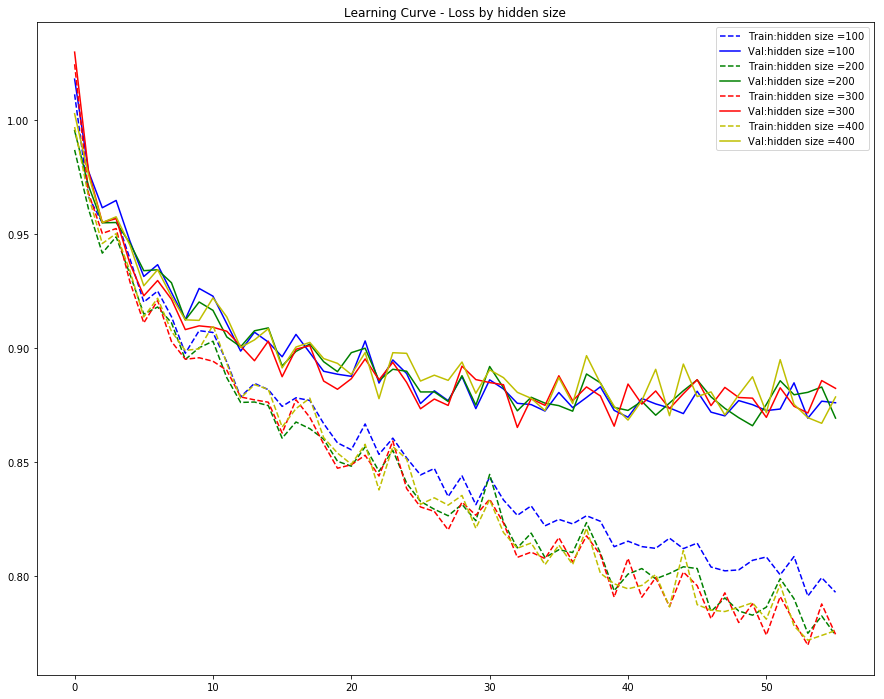

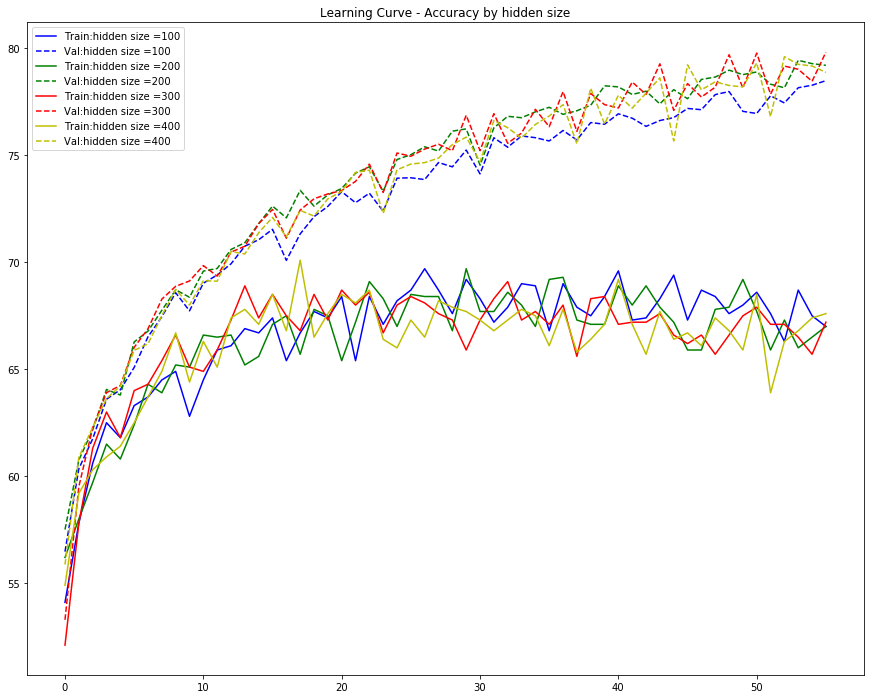

In [32]:
fig1, ax1 = plt.subplots(figsize=(15,12))
fig2, ax2 = plt.subplots(figsize=(15,12))
for i, hidden_size in enumerate([100, 200, 300, 400]):
    train_loss_l, val_loss_l, val_acc_l, train_acc_l, model = cnn_train(emb_size=pre_embedding.size(1), hidden_size=hidden_size, num_layers=2, 
            num_classes=3, vocab_size=pre_embedding.size(0), kernel_size = 3, dropout=0)
    # loss
    ax1.plot(range(len(train_loss_l)), train_loss_l,'--', label = 'Train:hidden size ='+str(hidden_size), color = co[i])
    ax1.plot(range(len(val_loss_l)), val_loss_l, label = 'Val:hidden size ='+str(hidden_size), color = co[i])
    # acc
    ax2.plot(range(len(val_acc_l)), val_acc_l, label = 'Train:hidden size ='+str(hidden_size), color = co[i])
    ax2.plot(range(len(train_acc_l)), train_acc_l, '--', label = 'Val:hidden size ='+str(hidden_size), color = co[i])
    print(sum([np.prod(p.size()) for p in filter(lambda p: p.requires_grad, model.parameters())]))
    ax1.legend(loc = 'best')
    ax2.legend(loc = 'best')
ax1.set_title('Learning Curve - Loss by hidden size')
ax2.set_title('Learning Curve - Accuracy by hidden size')
#fig1.legend()
#fig2.legend()
fig1.show()
fig2.show()
fig1.savefig('/home/hb1500/nlph2_result/Learning_Curve_Loss_by_hidden size.png')
fig2.savefig('/home/hb1500/nlph2_result/Learning_Curve_Accuracy_by_hidden_size.png')

#### Varying  the kernel size of CNN


  0%|          | 0/8 [00:00<?, ?it/s]

CNN_hidden_size_100_kernel_size_1.txt



Exception in thread Thread-7:
Traceback (most recent call last):
  File "/share/apps/python3/3.6.3/intel/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/share/apps/python3/3.6.3/intel/lib/python3.6/site-packages/tqdm-4.19.4-py3.6.egg/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/hb1500/py3.6.3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

  0%|          | 0/8 [00:00<?, ?it/s]

81003
CNN_hidden_size_100_kernel_size_2.txt


  0%|          | 0/8 [00:00<?, ?it/s]

121003
CNN_hidden_size_100_kernel_size_3.txt


100%|██████████| 8/8 [13:58<00:00, 104.83s/it]
/share/apps/python3/3.6.3/intel/lib/python3.6/site-packages/matplotlib-2.1.0-py3.6-linux-x86_64.egg/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


161003


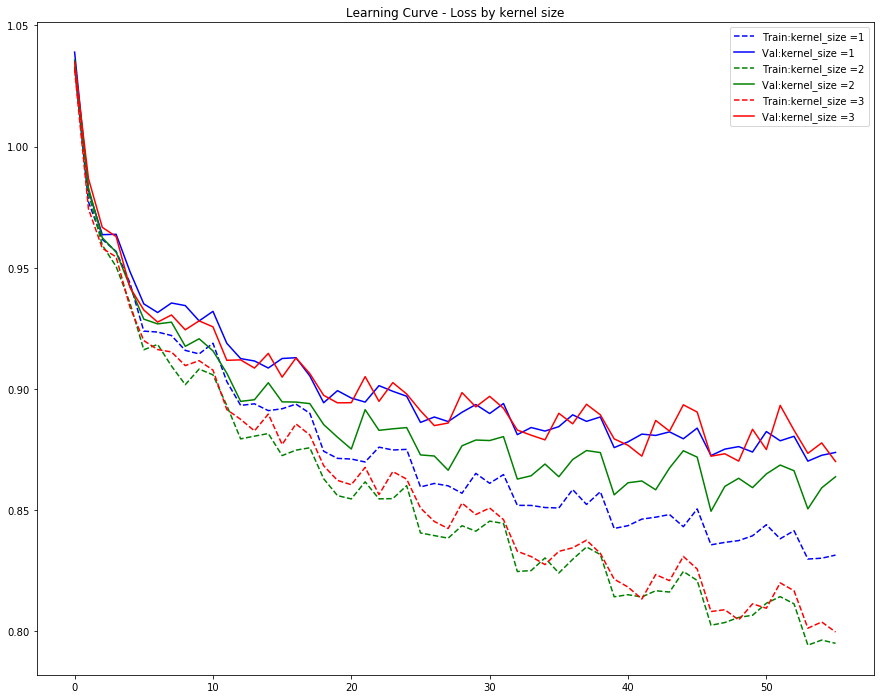

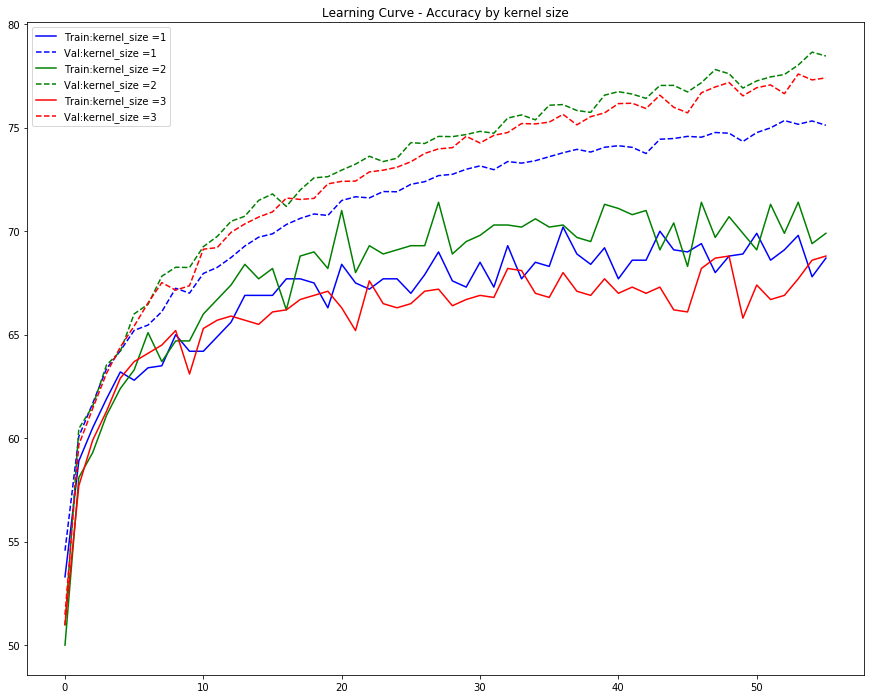

In [107]:
fig1, ax1 = plt.subplots(figsize=(15,12))
fig2, ax2 = plt.subplots(figsize=(15,12))
for i, kernel_size in enumerate([1,2,3]):
    train_loss_l, val_loss_l, val_acc_l, train_acc_l, model = cnn_train(emb_size=pre_embedding.size(1), hidden_size= 100, num_layers=2, 
            num_classes=3, vocab_size=pre_embedding.size(0), kernel_size = kernel_size, dropout=0)
    # loss
    ax1.plot(range(len(train_loss_l)), train_loss_l,'--', label = 'Train:kernel_size ='+str(kernel_size), color = co[i])
    ax1.plot(range(len(val_loss_l)), val_loss_l, label = 'Val:kernel_size ='+str(kernel_size), color = co[i])
    # acc
    ax2.plot(range(len(val_acc_l)), val_acc_l, label = 'Train:kernel_size ='+str(kernel_size), color = co[i])
    ax2.plot(range(len(train_acc_l)), train_acc_l, '--', label = 'Val:kernel_size ='+str(kernel_size), color = co[i])
    print(sum([np.prod(p.size()) for p in filter(lambda p: p.requires_grad, model.parameters())]))
    ax1.legend(loc = 'best')
    ax2.legend(loc = 'best')
    
ax1.set_title('Learning Curve - Loss by kernel size')
ax2.set_title('Learning Curve - Accuracy by kernel size')
# fig1.legend()
# fig2.legend()
fig1.show()
fig2.show()
fig1.savefig('/home/hb1500/nlph2_result/Learning_Curve_Loss_by_kernel_size.png')
fig2.savefig('/home/hb1500/nlph2_result/Learning_Curve_Accuracy_by_kernel_size.png')

### Train best CNN model with hidden_dim = 100 and kernel size = 2

In [ ]:
model = CNN(emb_size=pre_embedding.size(1), hidden_size=100, num_layers=2, 
            num_classes=3, vocab_size=pre_embedding.size(0), kernel_size = 2, dropout=0)
model = model.to(device)

learning_rate = 3e-3
num_epochs = 5 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

train_loss_l = []
val_loss_l = []
train_acc_l = []
val_acc_l = []
#myfile = open('/home/hb1500/nlph2_result/test.txt', 'w')
for epoch in range(num_epochs):
    for i, (data1, lengths1, data2, lengths2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1.to(device).long(), lengths1.to(device).long(), 
                        data2.to(device).long(), lengths2.to(device).long())
        loss = criterion(outputs, labels.to(device))
        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc, val_loss = test_model(val_loader, model)
            train_acc, train_loss = test_model(train_loader, model)
            train_loss_l.append(train_loss)
            val_loss_l.append(val_loss)
            train_acc_l.append(train_acc)
            val_acc_l.append(val_acc)            
            print('Epoch: [{}/{}], Step: [{}/{}], Train Acc: {}, Validation Acc: {}, Train Loss: {}, Validatoin Loss: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), train_acc, val_acc, train_loss, val_loss))
            #line = 'Epoch: [{}/{}], Step: [{}/{}], Train Acc: {}, Validation Acc: {}, Train Loss: {}, Validatoin Loss: {}'.format(
                       #epoch+1, num_epochs, i+1, len(train_loader), train_acc, val_acc, train_loss, val_loss)
            #myfile.write("%s\n" % line)    
#myfile.close()

### List 3 correct and 3 incorrect predictions

In [64]:
model.eval()
for data1, lengths1, data2, lengths2, labels in val_loader:    
    data_batch1, lengths_batch1, data_batch2, lengths_batch2, label_batch = data1, lengths1, data2, lengths2, labels
    outputs = F.softmax(model(data1.to(device).long(), lengths1.to(device).long(), 
                              data2.to(device).long(), lengths2.to(device).long()), dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    break
    
def loaddata(filepath):
    '''returns cleaned dataset [[[sentence1],[sentence2],label],...]'''
    dataset = []
    with open(filepath) as tsvfile:
        reader = csv.reader(tsvfile, delimiter='\t')
        next(reader)
        for row in reader:
            dataset.append(row)
    return dataset

origin_val = loaddata('/scratch/hb1500/NLP/HW2/hw2_data/snli_val.tsv')

correct = []
incorrect = []
for i, v in enumerate(predicted):
    if val_set[i][-1] == v:
        correct.append([origin_val[i][0], origin_val[i][1], v, val_set[i][-1], origin_val[i][-1]])
    else:
        incorrect.append([origin_val[i][0], origin_val[i][1], v, val_set[i][-1], origin_val[i][-1]])

In [65]:
correct[0:3]

[['Four people sit on a subway two read books , one looks at a cellphone and is wearing knee high boots .',
  'Multiple people are on a subway together , with each of them doing their own thing .',
  tensor([0], device='cuda:0'),
  0,
  'entailment'],
 ['bicycles stationed while a group of people socialize .',
  'People get together near a stand of bicycles .',
  tensor([0], device='cuda:0'),
  0,
  'entailment'],
 ['Man in overalls with two horses .',
  'a man in overalls with two horses',
  tensor([0], device='cuda:0'),
  0,
  'entailment']]

In [66]:
incorrect[0:3]

[['Three women on a stage , one wearing red shoes , black pants , and a gray shirt is sitting on a prop , another is sitting on the floor , and the third wearing a black shirt and pants is standing , as a gentleman in the back tunes an instrument .',
  'There are two women standing on the stage',
  tensor([0], device='cuda:0'),
  2,
  'contradiction'],
 ['Two people are in a green forest .',
  'The forest is not dead .',
  tensor([2], device='cuda:0'),
  0,
  'entailment'],
 ['Two men are listening to music through headphones .',
  'Two men listen to music .',
  tensor([2], device='cuda:0'),
  0,
  'entailment']]

### Evaluation on MultiNLI

In [33]:
mnli_val = tokenize('/scratch/hb1500/NLP/HW2/hw2_data/mnli_val.tsv')

In [34]:
# check different genres in MNLI
genre = []
for i in range(len(mnli_val)):
    genre.append(mnli_val[i][-1])
genre = list(set(genre))

In [35]:
genre

['travel', 'slate', 'fiction', 'government', 'telephone']

In [36]:
mnli_val_slate = []
mnli_val_travel = []
mnli_val_telephone = []
mnli_val_government = []
mnli_val_fiction = []
for i, v in enumerate(mnli_val):
    if v[-1] == 'slate':
        mnli_val_slate.append([v[0],v[1],v[2]])
    if v[-1] == 'travel':
        mnli_val_travel.append([v[0],v[1],v[2]])
    if v[-1] == 'telephone':
        mnli_val_telephone.append([v[0],v[1],v[2]])
    if v[-1] == 'government':
        mnli_val_government.append([v[0],v[1],v[2]])
    if v[-1] == 'fiction':
        mnli_val_fiction.append([v[0],v[1],v[2]])    

In [37]:
mnli_val_slate_indices = token2index_dataset(mnli_val_slate)
mnli_val_travel_indices = token2index_dataset(mnli_val_travel)
mnli_val_telephone_indices = token2index_dataset(mnli_val_telephone)
mnli_val_government_indices = token2index_dataset(mnli_val_government)
mnli_val_fiction_indices = token2index_dataset(mnli_val_fiction)

In [38]:
BATCH_SIZE = 128
test_mnli_val_slate = SNLIDataset(mnli_val_slate_indices)
test_loader_mnli_slate = torch.utils.data.DataLoader(dataset=test_mnli_val_slate, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=False)
test_mnli_val_travel = SNLIDataset(mnli_val_travel_indices)
test_loader_mnli_travel = torch.utils.data.DataLoader(dataset=test_mnli_val_travel, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=False)
test_mnli_val_telephone = SNLIDataset(mnli_val_telephone_indices)
test_loader_mnli_telephone = torch.utils.data.DataLoader(dataset=test_mnli_val_telephone, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=False)
test_mnli_val_government = SNLIDataset(mnli_val_government_indices)
test_loader_mnli_government = torch.utils.data.DataLoader(dataset=test_mnli_val_government, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=False)
test_mnli_val_fiction = SNLIDataset(mnli_val_fiction_indices)
test_loader_mnli_val_fiction = torch.utils.data.DataLoader(dataset=test_mnli_val_fiction, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=False)

In [63]:
print('CNN best model test on MNLI validation set:')

slate_acc ,_ = test_model(test_loader_mnli_slate, model)
print('slate:', slate_acc)

travel_acc ,_ = test_model(test_loader_mnli_travel, model)
print('travel:', travel_acc)

telephone_acc ,_ = test_model(test_loader_mnli_telephone, model)
print('telephone:', telephone_acc)

government_acc ,_ = test_model(test_loader_mnli_government, model)
print('government:', government_acc)

fiction_acc ,_ = test_model(test_loader_mnli_val_fiction, model)
print('fiction:', fiction_acc)

CNN best model test on MNLI validation set:
slate: 43.31337325349301
travel: 47.86150712830957
telephone: 41.29353233830846
government: 45.86614173228347
fiction: 42.10752866849007
